# Decompose velocities from multiple lines of sight

One of the benefits of having datasets from different viewing geometries (e.g. ascending and descending tracks) is that it is possible to decompose the velocities in areas of overlap into their vertical and horizontal components. Let's try it here! 

# 1. Dependencies and functions

The dependencies are the same as those that MintPy needs $-$ so make sure they are installed!

In [1]:
# let's start with some dependencies 
# (needless to say if they are not installed, jupyter will be sad)
import numpy as np
import math
import matplotlib.pyplot as plt
from osgeo import gdal, osr
from mintpy.utils import readfile, utils as ut

In [2]:
# here is little function to find the nearest neighbor to a value in an array
# (minimal alteration from stack overflow)
def closest(lst, K):  
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return idx

## 2. Load in and crop the data

The first step is to read in the data. Here we are using data from MintPy, although this ought to work for other datasets too. Each MintPy file contains a mixture of data layers ('subdatasets') and metadata information ('attributes') $-$ and we want both, ideally. 

This is a bit fiddly... we need to first read the attributes for each track in turn, to figure out the file dimensions and coordinates. Then we want load in multiple data layers from multiple files, and crop them to the same dimensions. Reading the attributes is easiest using one of the MintPy utilities, and we'll use Gdal for the actual data loading. The data files are HDF5 format, which is versatile, but potentially very complicated! 

The file 'velocity.h5' for each track contains two layers $-$ the velocity data, and the $1\sigma$ uncertainty in the velocity. We want them both.

The other file, 'geometryGeo.h5' for each track contains four layers. We want two of them $-$ layer 0 (which contains 'azimuth' $-$ pointing direction $-$ information), and layer 2 (which contains incidence information).

To add a little more complication, it seems that MintPy is a little sloppy with coordinates, in that data which ought to have the same pixel coordinates, don't, and distances which ought to be spanned by neat round numbers of pixels (by design!) aren't. So I had to bodge it a little. Oh well... it's probably accurate to a pixel or so.

In [3]:
# for MintPy h5 files
# some file locations, names and details
dscdir='../d071/MintPy/'
ascdir='../a064/MintPy/'

# define your crop area
crop_minx=-118.0
crop_maxx=-117.6
crop_maxy=36.15
crop_miny=35.9

# MintPy filenames
velofile='velocity.h5'
geomfile='inputs/geometryGeo.h5'

# ------
# we begin with the descending data

# read in data and metadata for the descending data
print('reading data file '+dscdir+velofile)
data, atr = readfile.read(dscdir+velofile)

# extract lat/lon information from the attributes
lat0 = float(atr['Y_FIRST']);  lat_step = float(atr['Y_STEP']);  lat_num = int(atr['LENGTH'])
lon0 = float(atr['X_FIRST']);  lon_step = float(atr['X_STEP']);  lon_num = int(atr['WIDTH'])
lat1 = lat0 + lat_step * lat_num
lon1 = lon0 + lon_step * lon_num
lats, lons = np.mgrid[lat0:lat1:lat_num*1j,
                      lon0:lon1:lon_num*1j]

# find the crop extents
mincol = closest(lons[0], crop_minx)
maxcol = closest(lons[0], crop_maxx)
maxrow = closest(lats[:,0], crop_miny)
minrow = closest(lats[:,0], crop_maxy)

# optional bodge
maxcol+=1
maxrow+=1

print('  minimum longitude: {0:f}, closest column {1:d}, closest longitude: {2:f}'
      .format(crop_minx, mincol, lons[0,mincol]))
print('  maximum longitude: {0:f}, closest column {1:d}, closest longitude: {2:f}'
      .format(crop_maxx, maxcol, lons[0,maxcol]))
print('  minimum latitude: {0:f}, closest row {1:d}, closest latitude: {2:f}'
      .format(crop_miny, maxrow, lats[maxrow,0]))
print('  maximum latitude: {0:f}, closest row {1:d}, closest latitude: {2:f}'
      .format(crop_maxy, minrow, lats[minrow,0]))

# read in velocity and error data, and crop them
dscveloin=gdal.Open(dscdir+velofile,gdal.GA_ReadOnly)
dsctmp=gdal.Open(dscveloin.GetSubDatasets()[0][0]).ReadAsArray()
dscvel=dsctmp[minrow:maxrow,mincol:maxcol]
dsctmp=gdal.Open(dscveloin.GetSubDatasets()[1][0]).ReadAsArray()
dscerr=dsctmp[minrow:maxrow,mincol:maxcol]

# read in azimuth and incidence information
dscgeomin=gdal.Open(dscdir+geomfile,gdal.GA_ReadOnly)
dsctmp=gdal.Open(dscgeomin.GetSubDatasets()[0][0]).ReadAsArray()
dscazi=dsctmp[minrow:maxrow,mincol:maxcol]
dsctmp=gdal.Open(dscgeomin.GetSubDatasets()[2][0]).ReadAsArray()
dscinc=dsctmp[minrow:maxrow,mincol:maxcol]


# ------
# and now for the ascending data...

# read in data and metadata for the descending data
print('reading data file '+ascdir+velofile)
data, atr = readfile.read(ascdir+velofile)

# extract lat/lon information from the attributes
lat0 = float(atr['Y_FIRST']);  lat_step = float(atr['Y_STEP']);  lat_num = int(atr['LENGTH'])
lon0 = float(atr['X_FIRST']);  lon_step = float(atr['X_STEP']);  lon_num = int(atr['WIDTH'])
lat1 = lat0 + lat_step * lat_num
lon1 = lon0 + lon_step * lon_num
lats, lons = np.mgrid[lat0:lat1:lat_num*1j,
                      lon0:lon1:lon_num*1j]

# find the crop extents
mincol = closest(lons[0], crop_minx)
maxcol = closest(lons[0], crop_maxx)
maxrow = closest(lats[:,0], crop_miny)
minrow = closest(lats[:,0], crop_maxy)

# optional bodge
maxcol+=1
maxrow+=1

print('  minimum longitude: {0:f}, closest column {1:d}, closest longitude: {2:f}'
      .format(crop_minx, mincol, lons[0,mincol]))
print('  maximum longitude: {0:f}, closest column {1:d}, closest longitude: {2:f}'
      .format(crop_maxx, maxcol, lons[0,maxcol]))
print('  minimum latitude: {0:f}, closest row {1:d}, closest latitude: {2:f}'
      .format(crop_miny, maxrow, lats[maxrow,0]))
print('  maximum latitude: {0:f}, closest row {1:d}, closest latitude: {2:f}'
      .format(crop_maxy, minrow, lats[minrow,0]))

# read in velocity and error data, and crop them
ascveloin=gdal.Open(ascdir+velofile,gdal.GA_ReadOnly)
asctmp=gdal.Open(ascveloin.GetSubDatasets()[0][0]).ReadAsArray()
ascvel=asctmp[minrow:maxrow,mincol:maxcol]
asctmp=gdal.Open(ascveloin.GetSubDatasets()[1][0]).ReadAsArray()
ascerr=asctmp[minrow:maxrow,mincol:maxcol]

# read in azimuth and incidence information
ascgeomin=gdal.Open(ascdir+geomfile,gdal.GA_ReadOnly)
asctmp=gdal.Open(ascgeomin.GetSubDatasets()[0][0]).ReadAsArray()
ascazi=asctmp[minrow:maxrow,mincol:maxcol]
asctmp=gdal.Open(ascgeomin.GetSubDatasets()[2][0]).ReadAsArray()
ascinc=asctmp[minrow:maxrow,mincol:maxcol]

# ------
# and for one final flourish, we can make some coordinate matrices, masks, all the good stuff 

mask=((dscvel!=0)&(ascvel!=0))
nrows = dscvel[:,0].size
ncols = dscvel[0].size
xx=np.linspace(crop_minx,crop_maxx,ncols)
yy=np.linspace(crop_maxy,crop_miny,nrows)
X, Y = np.meshgrid(xx,yy)

reading data file ../d071/MintPy/velocity.h5
  minimum longitude: -118.000000, closest column 121, closest longitude: -118.000297
  maximum longitude: -117.600000, closest column 602, closest longitude: -117.598986
  minimum latitude: 35.900000, closest row 422, closest latitude: 35.898932
  maximum latitude: 36.150000, closest row 121, closest latitude: 36.150230
reading data file ../a064/MintPy/velocity.h5
  minimum longitude: -118.000000, closest column 121, closest longitude: -118.000297
  maximum longitude: -117.600000, closest column 602, closest longitude: -117.598986
  minimum latitude: 35.900000, closest row 422, closest latitude: 35.898932
  maximum latitude: 36.150000, closest row 121, closest latitude: 36.150230


We can check that the data loaded OK, with a little light plotting:

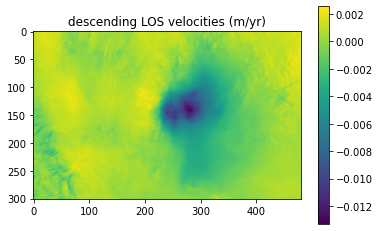

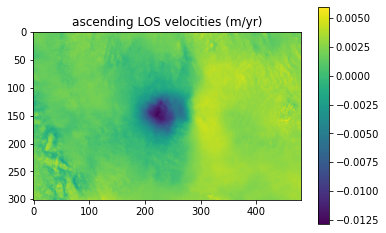

In [10]:
# let's plot the cropped data
fig1, ax1 = plt.subplots()                       # initiate a matplotlib plot
im1 = ax1.imshow(dscvel)                         # plot displacements
ax1.set_title('descending LOS velocities (m/yr)')
fig1.colorbar(im1)                                # plot a color bar!
fig2, ax2 = plt.subplots()                       # initiate a matplotlib plot
im2 = ax2.imshow(ascvel)                         # plot displacements 
ax2.set_title('ascending LOS velocities (m/yr)')
fig2.colorbar(im2)                                # plot a color bar!


plt.show();

## 3. Apply a reference point

We want to give our datasets a common reference point (in case you didn't already), so that zero velocity is consistent. I recommend you pick a stable location, i.e. not a place where there is a lot of deformation, such as a bedrock outcrop if possible (look in Google Earth). Even better $-$ if there are any nearby, pick a stable location with a continuous GNSS station!

In [5]:
# long and lat of a stable reference point
ref_x=-117.8322
ref_y=35.9567 

# and find it in your coordinate system
refcol=closest(xx,ref_x)
refrow=closest(yy,ref_y)

# shift and mask your data
dscvel=(dscvel-dscvel[refrow,refcol])*mask
ascvel=(ascvel-ascvel[refrow,refcol])*mask

# wasn't that easy!

## 4. Loop through the images and invert for vertical and horizontal!

This is the meaty part of the problem.

In [6]:
# what sign convention are you using?
sign_convention=-1   # 1 for range change, -1 for ground displacement (MintPy default)

# report the sign convention
if sign_convention==1:
    print('range change sign convention')
elif sign_convention==-1:
    print('ground displacement sign convention')
else:
    print('you may have messed up this sign convention thing, to be honest')


# make a place to put your outputs
hvel=np.zeros((nrows,ncols))
herr=np.zeros((nrows,ncols))
vvel=np.zeros((nrows,ncols))
verr=np.zeros((nrows,ncols))

# loop through rows and columns of the data!

for i in range(nrows):
    
    for j in range(ncols):
        
        # if there isn't any data there
        if dscvel[i,j]==0 and ascvel[i,j]==0:     # null pixel
            
            # and it's not the reference point
            if i!=refrow and j!=refcol:
                hvel[i,j]=math.nan;      # blank out the output!
                herr[i,j]=math.nan;
                vvel[i,j]=math.nan;
                verr[i,j]=math.nan;
            
        else:                                     # we have a live one!
            
            # calculate the unit LOS vectors (satellite pointing to ground target)
            # (this all assumes angles using the ISCE convention, in degrees)
            
            dsc_los=np.array([np.sin(np.radians(dscazi[i,j]))*np.sin(np.radians(dscinc[i,j])),
                  -np.cos(np.radians(dscazi[i,j]))*np.sin(np.radians(dscinc[i,j])),
                  -np.cos(np.radians(dscinc[i,j]))])*sign_convention

            asc_los=np.array([np.sin(np.radians(ascazi[i,j]))*np.sin(np.radians(ascinc[i,j])),
                  -np.cos(np.radians(ascazi[i,j]))*np.sin(np.radians(ascinc[i,j])),
                  -np.cos(np.radians(ascinc[i,j]))])*sign_convention

            # take east and vertical components of LOS and make the design matrix from them
            A=np.array([[dsc_los[0], dsc_los[2]],
                        [asc_los[0], asc_los[2]]])
            
            # take the errors from the data and make inverse variance weights from them
            W=np.array([[1/dscerr[i,j]**2, 0],
                        [0, 1/ascerr[i,j]**2]])
            
            # and finally, put the data into a column vector
            d=np.array([dscvel[i,j], ascvel[i,j]]).T
            
            # and invert!
            ATAinv=np.linalg.inv(np.matmul(np.matmul(A.T,W),A))
            ATd=np.matmul(np.matmul(A.T,W),d)
            m=np.matmul(ATAinv,ATd)
            
            # and then extract your answers
            hvel[i,j]=m[0]                   # horizontal velocity
            herr[i,j]=np.sqrt(ATAinv[0,0])   # 1-sigma uncertainty in horizontal velocity
            vvel[i,j]=m[1]                   # vertical velocity
            verr[i,j]=np.sqrt(ATAinv[1,1])   # ...and the 1-sigma uncertainty in that
        

ground displacement sign convention


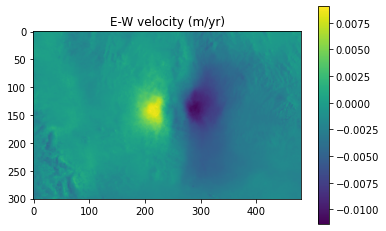

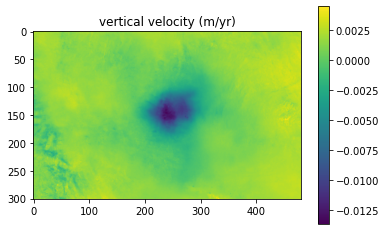

In [7]:
# let's plot the output
fig1, ax1 = plt.subplots()                       # initiate a matplotlib plot
im1 = ax1.imshow(hvel)                         # plot displacements
ax1.set_title('E-W velocity (m/yr)')
fig1.colorbar(im1)                                # plot a color bar!
fig2, ax2 = plt.subplots()                       # initiate a matplotlib plot
im2 = ax2.imshow(vvel)                         # plot displacements 
ax2.set_title('vertical velocity (m/yr)')
fig2.colorbar(im2)                                # plot a color bar!


plt.show();

In [21]:
# some file names
outvert='coso_vertical'
outhorz='coso_e-w'

# try to write out the vertical data in GeoTiff format
driver = gdal.GetDriverByName("GTiff")
outgrd = driver.Create(outvert+'.tiff', ncols, nrows, 1, gdal.GDT_Float32)
outgrd.SetGeoTransform((crop_minx, lon_step, 0, crop_maxy, 0, lat_step))
outgrdSRS = osr.SpatialReference()
outgrdSRS.ImportFromEPSG(4326)
outgrd.SetProjection(outgrdSRS.ExportToWkt())
outband = outgrd.GetRasterBand(1)
outband.WriteArray(vvel,0,0)
outband.FlushCache()         # need this to actually write anything!
outband.SetNoDataValue(0)
del outgrd, outband, outgrdSRS

# and again for the horizontal data
driver = gdal.GetDriverByName("GTiff")
outgrd = driver.Create(outhorz+'.tiff', ncols, nrows, 1, gdal.GDT_Float32)
outgrd.SetGeoTransform((crop_minx, lon_step, 0, crop_maxy, 0, lat_step))
outgrdSRS = osr.SpatialReference()
outgrdSRS.ImportFromEPSG(4326)
outgrd.SetProjection(outgrdSRS.ExportToWkt())
outband = outgrd.GetRasterBand(1)
outband.WriteArray(hvel,0,0)
outband.FlushCache()
outband.SetNoDataValue(0)
del outgrd, outband, outgrdSRS